# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [3]:
def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    #raise Exception("TODO in computeHomography() not implemented")
    N = pts1.shape[1]
    A = np.zeros((2*N, 9))
    
    for i in range(N):
        x = pts1[:, i]
        y = pts2[:, i]
        u = x[0]
        v = x[1]
        u2 = y[0]
        v2 = y[1]
        A[2*i,:] = np.array([-u, -v, -1, 0, 0, 0, u*u2, v*u2, u2])
        A[2*i+1, :] = np.array([0, 0, 0, -u, -v, -1, u*v2, v*v2, v2])
    
    a,b,vh = np.linalg.svd(A)
    h = vh[vh.shape[0]-1,:]
    h = np.reshape(h, (3,3))
    return h

In [5]:
H = auto_homography(im2,im1, computeHomography)

best score: 155.000000


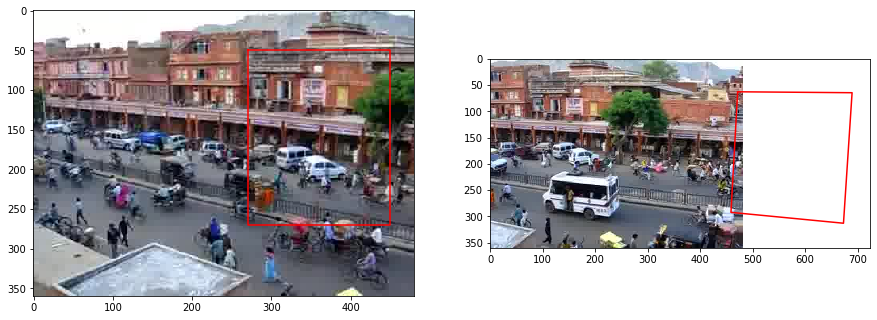

In [6]:
# Checking
plotA = np.array([270, 450, 450, 270, 270])
plotB = np.array([50, 50, 270, 270, 50])
ones = np.ones(5)
plotC = np.array([plotA, plotB, ones])
plotD = np.dot(H, plotC)
plotD = plotD / plotD[-1]

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

axes[0].imshow(im1)
axes[0].plot(plotA, plotB, 'r') #use red instead of blue
axes[1].imshow(im2)
axes[1].plot(plotD[0], plotD[1], 'r')

Text(0.5, 1.0, 'Blended Output')

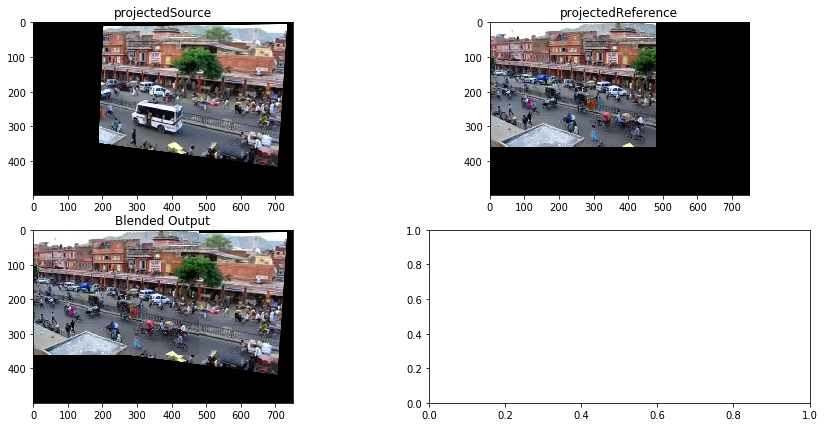

In [7]:
# # Example usage of cv2.warpPerspective
# projectedWidth = 1600
# projectedHeight = 500

projectedWidth = 750
projectedHeight = 500

sourceHomography = H
refHomography = np.identity(3)

projectedSource = cv2.warpPerspective(im2, sourceHomography, (projectedWidth, projectedHeight))
projectedReference = cv2.warpPerspective(im1, refHomography, (projectedWidth, projectedHeight))

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 7)

axes[0, 0].imshow(projectedSource)
axes[0, 0].set_title("projectedSource")
axes[0, 1].imshow(projectedReference)
axes[0, 1].set_title("projectedReference")

# Example usage of utils.blendImages
blendedOutput = utils.blendImages(projectedSource, projectedReference)
# blendedOutput = cv2.cvtColor(blendedOutput, cv2.COLOR_BGR2RGB)
# plt.figure()
# plt.imshow(blendedOutput)
axes[1, 0].imshow(blendedOutput)
axes[1, 0].set_title("Blended Output")

# cv2.imwrite("part1_projectedSource.jpg", projectedSource)
# cv2.imwrite("part1_projectedReference.jpg", projectedReference)
# cv2.imwrite("part1_blended.jpg", blendedOutput)

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [8]:
import cv2
import numpy as np

In [9]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

im1 = cv2.imread('./images/input/frames/f0090.jpg')
im2 = cv2.imread('./images/input/frames/f0270.jpg')
im3 = cv2.imread('./images/input/frames/f0450.jpg')
im4 = cv2.imread('./images/input/frames/f0630.jpg')
im5 = cv2.imread('./images/input/frames/f0810.jpg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

best score: 190.000000
best score: 167.000000
best score: 128.000000
best score: 94.000000


True

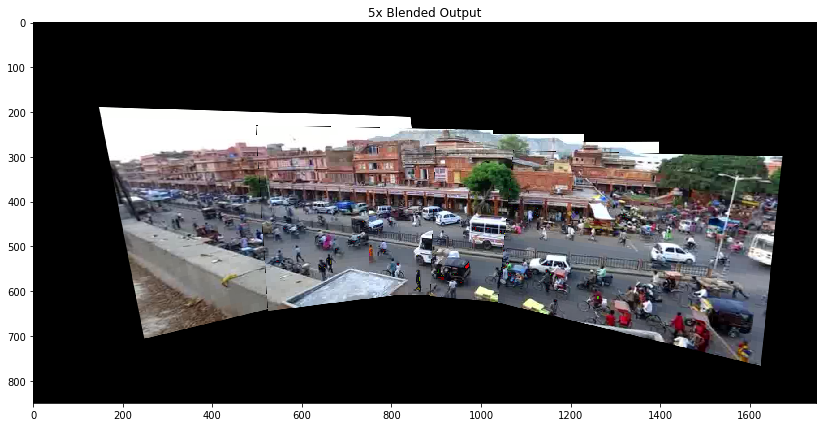

In [10]:
# projectedWidth = 750
# projectedHeight = 500

# sourceHomography = H
# refHomography = np.identity(3)

# projectedSource = cv2.warpPerspective(im2, sourceHomography, (projectedWidth, projectedHeight))
# projectedReference = cv2.warpPerspective(im1, refHomography, (projectedWidth, projectedHeight))
# blendedOutput = utils.blendImages(projectedSource, projectedReference)

fig, axes = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

projectedWidth = 1750
projectedHeight = 850

H_12 = auto_homography(im1,im2, computeHomography)
H_23 = auto_homography(im2,im3, computeHomography)
H_34 = auto_homography(im4,im3, computeHomography)
H_45 = auto_homography(im5,im4, computeHomography)

H_t = np.array([[1, 0, 750], [0, 1, 250], [0, 0, 1]])
refHomography = np.identity(3)

H_13 = np.dot(H_23,H_12)
H_35 = np.dot(H_45,H_34)

warped_1 = cv2.warpPerspective(im1, H_t.dot(H_13), (projectedWidth, projectedHeight))
warped_2 = cv2.warpPerspective(im2, H_t.dot(H_23), (projectedWidth, projectedHeight))
warped_3 = cv2.warpPerspective(im3, H_t.dot(refHomography), (projectedWidth, projectedHeight))
warped_4 = cv2.warpPerspective(im4, H_t.dot(H_34), (projectedWidth, projectedHeight))
warped_5 = cv2.warpPerspective(im5, H_t.dot(H_35), (projectedWidth, projectedHeight))

blend_1 = utils.blendImages(warped_1, warped_2)
blend_2 = utils.blendImages(blend_1, warped_3)
blend_3 = utils.blendImages(blend_2, warped_4)
blend_4 = utils.blendImages(blend_3, warped_5)
axes.imshow(blend_4)
axes.set_title("5x Blended Output")
cv2.imwrite("part2.jpg", blend_4)

### Part 3: Map the video to the reference plane

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

import utils

In [12]:
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [13]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [14]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [15]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0
print("Number of Pictures to Generate", len(frames)) #User line check

Number of Pictures to Generate 900


In [16]:
# Variables from Part 2 Still Being Used
# im1 = cv2.imread('./images/input/frames/f0090.jpg')
# im2 = cv2.imread('./images/input/frames/f0270.jpg')
# im3 = cv2.imread('./images/input/frames/f0450.jpg')
# im4 = cv2.imread('./images/input/frames/f0630.jpg')
# im5 = cv2.imread('./images/input/frames/f0810.jpg')

# im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
# im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
# im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
# im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
# im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

# projectedWidth = 1750
# projectedHeight = 850

# H_12 = auto_homography(im90,im270, computeHomography)
# H_23 = auto_homography(im270,im450, computeHomography)
# H_34 = auto_homography(im630,im450, computeHomography)
# H_45 = auto_homography(im810,im630, computeHomography)

# H_13 = np.dot(H_12,H_23)
# H_35 = np.dot(H_45,H_34)

# H_t = np.array([[1, 0, 750], [0, 1, 250], [0, 0, 1]]) #Used from Above

os.mkdir("aligned_frames")

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)

# Run through each file
for idx, file_i in enumerate(filenames):
    img = cv2.imread(file_i)
    if idx < 90:
        H = auto_homography(img,im1, computeHomography)
        H = np.dot(H,H_13)
        pastHomographies[idx] = H
        warped_1 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames/a{:04d}.jpg".format(idx), warped_1)
    elif (idx < 270) and (idx >= 90):
        H = auto_homography(img,im2, computeHomography)
        H = np.dot(H,H_23)
        pastHomographies[idx] = H
        warped_2 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames/a{:04d}.jpg".format(idx), warped_2)
    elif (idx >= 270) and (idx <= 630):
        H = auto_homography(img,im3, computeHomography)
        pastHomographies[idx] = H
        warped_3 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames/a{:04d}.jpg".format(idx), warped_3)
    elif (idx > 630) and (idx <= 810):
        H = auto_homography(img,im4, computeHomography)
        H = np.dot(H,H_34)
        pastHomographies[idx] = H
        warped_4 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames/a{:04d}.jpg".format(idx), warped_4)
    elif idx > 810:
        H = auto_homography(img,im5, computeHomography)
        H = np.dot(H,H_45)
        pastHomographies[idx] = H
        warped_5 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames/a{:04d}.jpg".format(idx), warped_5)

best score: 363.000000
best score: 356.000000
best score: 365.000000
best score: 353.000000
best score: 384.000000
best score: 383.000000
best score: 397.000000
best score: 404.000000
best score: 407.000000
best score: 417.000000
best score: 415.000000
best score: 409.000000
best score: 413.000000
best score: 401.000000
best score: 422.000000
best score: 429.000000
best score: 446.000000
best score: 429.000000
best score: 419.000000
best score: 418.000000
best score: 401.000000
best score: 423.000000
best score: 418.000000
best score: 407.000000
best score: 431.000000
best score: 412.000000
best score: 394.000000
best score: 428.000000
best score: 443.000000
best score: 428.000000
best score: 422.000000
best score: 454.000000
best score: 437.000000
best score: 427.000000
best score: 444.000000
best score: 456.000000
best score: 431.000000
best score: 443.000000
best score: 435.000000
best score: 459.000000
best score: 458.000000
best score: 450.000000
best score: 458.000000
best score:

best score: 214.000000
best score: 203.000000
best score: 211.000000
best score: 233.000000
best score: 219.000000
best score: 233.000000
best score: 261.000000
best score: 217.000000
best score: 207.000000
best score: 198.000000
best score: 209.000000
best score: 227.000000
best score: 216.000000
best score: 214.000000
best score: 276.000000
best score: 230.000000
best score: 242.000000
best score: 246.000000
best score: 232.000000
best score: 200.000000
best score: 255.000000
best score: 229.000000
best score: 199.000000
best score: 230.000000
best score: 226.000000
best score: 240.000000
best score: 228.000000
best score: 254.000000
best score: 238.000000
best score: 240.000000
best score: 263.000000
best score: 225.000000
best score: 247.000000
best score: 225.000000
best score: 236.000000
best score: 220.000000
best score: 232.000000
best score: 270.000000
best score: 272.000000
best score: 245.000000
best score: 266.000000
best score: 219.000000
best score: 249.000000
best score:

best score: 165.000000
best score: 176.000000
best score: 159.000000
best score: 150.000000
best score: 152.000000
best score: 135.000000
best score: 139.000000
best score: 152.000000
best score: 150.000000
best score: 160.000000
best score: 157.000000
best score: 142.000000
best score: 144.000000
best score: 126.000000
best score: 140.000000
best score: 127.000000
best score: 134.000000
best score: 131.000000
best score: 122.000000
best score: 122.000000
best score: 148.000000
best score: 127.000000
best score: 128.000000
best score: 135.000000
best score: 131.000000
best score: 128.000000
best score: 135.000000
best score: 150.000000
best score: 119.000000
best score: 144.000000
best score: 133.000000
best score: 130.000000
best score: 126.000000
best score: 118.000000
best score: 119.000000
best score: 118.000000
best score: 113.000000
best score: 118.000000
best score: 107.000000
best score: 132.000000
best score: 110.000000
best score: 101.000000
best score: 108.000000
best score:

In [17]:
utils.imageFolder2mpeg('aligned_frames', fps=30)

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
#Variables Copied from Above. "Reset" frames variable to use panoramaFrames
dir_frames = 'aligned_frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
# frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
panoramaFrames = np.zeros((frameCount, projectedHeight, projectedWidth, frameChannels),dtype=np.float32)
print("Scanning")
for idx, file_i in enumerate(filenames):
    panoramaFrames[idx] = cv2.imread(file_i) / 255.0

backgroundPanorama = np.zeros((projectedHeight, projectedWidth, 3))
print("Starting")
for a in range(projectedHeight):
    for b in range(projectedWidth):
        for c in range(3):
            pixel = np.nonzero(panoramaFrames[:, a, b, c])
            # Calculate Median and populate for output
            if len(pixel) > 0:
                backgroundPanorama[a][b][c] = np.median(panoramaFrames[pixel, a, b, c])

print("Done")

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


True

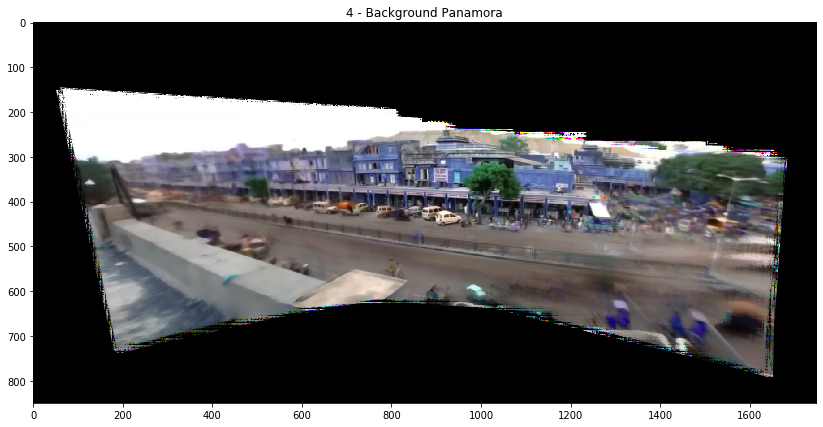

In [20]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

axes.imshow(backgroundPanorama)
axes.set_title("4 - Background Panamora")
cv2.imwrite("part4.jpg", backgroundPanorama*255)

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [21]:
import os
import cv2
import numpy as np

In [22]:
# https://piazza.com/class/k5cumohrew35en?cid=876
os.mkdir("part5")

# background_images = np.zeros((900,projectedHeight, projectedWidth,3))
background_images = np.zeros((900, 360, 480,3))

for idx in range(0, 900):
    invertedH = np.linalg.inv(H_t.dot(pastHomographies[idx][450]))
#     projected_image = cv2.warpPerspective(backgroundPanorama, invertedH, (projectedWidth, projectedHeight))
    projected_image = cv2.warpPerspective(backgroundPanorama, invertedH, (480, 360))
    background_images[idx,:,:,:] = projected_image
    cv2.imwrite('part5/a{:04d}.jpg'.format(idx), projected_image*255)

In [23]:
utils.imageFolder2mpeg('part5', fps=30)

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [24]:
import os
import cv2
import numpy as np

In [25]:
os.mkdir("part6")
for idx in range(0, 900):
    difference = frames[idx] - background_images[idx]
    cv2.imwrite('part6/a{:04d}.jpg'.format(idx), difference*255)

In [26]:
utils.imageFolder2mpeg('part6', fps=30)

## Bells and whistles

### Part 7*: Generate a wide video [10 pts]

In Part 5 you created a background movie by projecting back the panorama background to each frame plane. If you map a wider area you will get a wider background movie. You can use this background movie to extend the borders of your video and make it wider. The extended video must be at least 50% wider. You can keep the same height.

In [32]:
# https://piazza.com/class/k5cumohrew35en?cid=876
os.mkdir("wide")
background_images2 = np.zeros((900,projectedHeight, projectedWidth,3))
for idx in range(0, 900):
    invertedH = np.linalg.inv(H_t.dot(pastHomographies[idx][450]))
    projected_image2 = cv2.warpPerspective(backgroundPanorama, invertedH, (1750, 850))
    background_images2[idx,:,:,:] = projected_image2
    cv2.imwrite('wide/a{:04d}.jpg'.format(idx), projected_image2*255)

In [33]:
utils.imageFolder2mpeg('wide', fps=30)

### Part 8: Process two more videos [up to 40 points]

You can apply the seven parts of the main project on two other videos. You get 20 points for processing one additional video and 40 points for processing two. If you do two additional videos, one of them must be your own. You get full points if you complete the first six parts of the main project.

I will be processing one additional video

#### Part 8.1: Stitch two key frames


In [34]:
import cv2
import numpy as np
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

In [35]:
# Outputs 2711
# MANUALLY DELETE, keep 2000-2722, rename the images used for reference to reflence. 
# f2070, f2210, f2350, f2490, f2630

# os.mkdir("convertedImages2")
# utils.video2imageFolder('street1.mp4', "convertedImages2")

In [36]:
# images location
im1 = './images/input/frames2/f2210.jpg'
im2 = './images/input/frames2/f2350.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [37]:
H = auto_homography(im2,im1, computeHomography)

best score: 383.000000


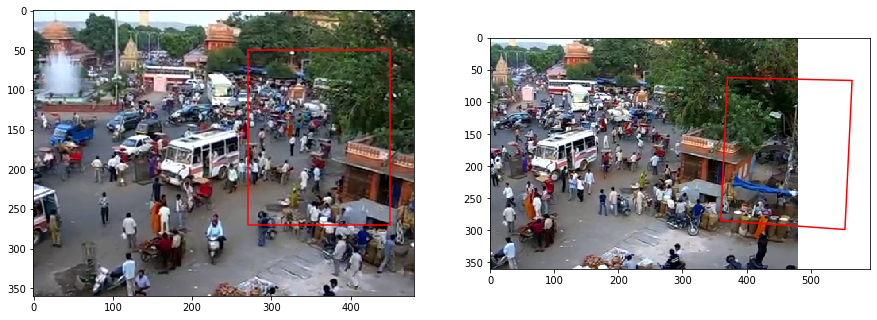

In [38]:
# Checking
plotA = np.array([270, 450, 450, 270, 270])
plotB = np.array([50, 50, 270, 270, 50])
ones = np.ones(5)
plotC = np.array([plotA, plotB, ones])
plotD = np.dot(H, plotC)
plotD = plotD / plotD[-1]

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

axes[0].imshow(im1)
axes[0].plot(plotA, plotB, 'r') #use red instead of blue
axes[1].imshow(im2)
axes[1].plot(plotD[0], plotD[1], 'r')

Text(0.5, 1.0, 'Blended Output')

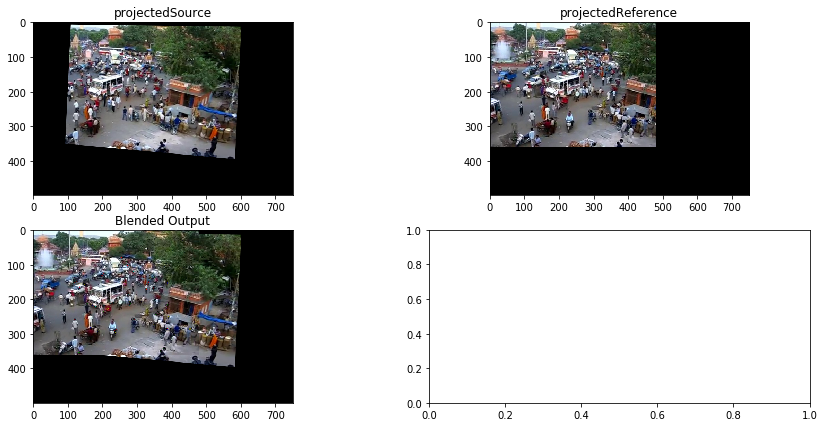

In [39]:
# # Example usage of cv2.warpPerspective
# projectedWidth = 1600
# projectedHeight = 500

projectedWidth = 750
projectedHeight = 500

sourceHomography = H
refHomography = np.identity(3)

projectedSource = cv2.warpPerspective(im2, sourceHomography, (projectedWidth, projectedHeight))
projectedReference = cv2.warpPerspective(im1, refHomography, (projectedWidth, projectedHeight))

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 7)

axes[0, 0].imshow(projectedSource)
axes[0, 0].set_title("projectedSource")
axes[0, 1].imshow(projectedReference)
axes[0, 1].set_title("projectedReference")

# Example usage of utils.blendImages
blendedOutput = utils.blendImages(projectedSource, projectedReference)
# blendedOutput = cv2.cvtColor(blendedOutput, cv2.COLOR_BGR2RGB)
# plt.figure()
# plt.imshow(blendedOutput)
axes[1, 0].imshow(blendedOutput)
axes[1, 0].set_title("Blended Output")

# cv2.imwrite("2-part1_projectedSource.jpg", projectedSource)
# cv2.imwrite("2-part1_projectedReference.jpg", projectedReference)
# cv2.imwrite("2-part1_blended.jpg", blendedOutput)

#### Part 8.2: Map the video to the reference plane

In [40]:
import cv2
import numpy as np

In [41]:
master_frames = [70, 210, 350, 490, 630]
reference_frame = 350
reference_idx = master_frames.index(reference_frame)

im1 = cv2.imread('./images/input/frames2/f2070.jpg')
im2 = cv2.imread('./images/input/frames2/f2210.jpg')
im3 = cv2.imread('./images/input/frames2/f2350.jpg')
im4 = cv2.imread('./images/input/frames2/f2490.jpg')
im5 = cv2.imread('./images/input/frames2/f2630.jpg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

best score: 348.000000
best score: 375.000000
best score: 590.000000
best score: 752.000000


Text(0.5, 1.0, '5x Blended Output')

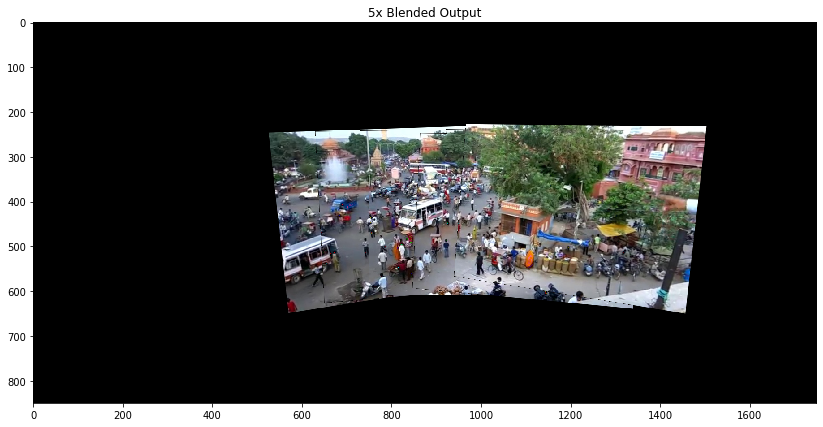

In [42]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

projectedWidth = 1750
projectedHeight = 850

H_12 = auto_homography(im1,im2, computeHomography)
H_23 = auto_homography(im2,im3, computeHomography)
H_34 = auto_homography(im4,im3, computeHomography)
H_45 = auto_homography(im5,im4, computeHomography)

H_t = np.array([[1, 0, 750], [0, 1, 250], [0, 0, 1]])
refHomography = np.identity(3)

H_13 = np.dot(H_23,H_12)
H_35 = np.dot(H_45,H_34)

warped_1 = cv2.warpPerspective(im1, H_t.dot(H_13), (projectedWidth, projectedHeight))
warped_2 = cv2.warpPerspective(im2, H_t.dot(H_23), (projectedWidth, projectedHeight))
warped_3 = cv2.warpPerspective(im3, H_t.dot(refHomography), (projectedWidth, projectedHeight))
warped_4 = cv2.warpPerspective(im4, H_t.dot(H_34), (projectedWidth, projectedHeight))
warped_5 = cv2.warpPerspective(im5, H_t.dot(H_35), (projectedWidth, projectedHeight))

blend_1 = utils.blendImages(warped_1, warped_2)
blend_2 = utils.blendImages(blend_1, warped_3)
blend_3 = utils.blendImages(blend_2, warped_4)
blend_4 = utils.blendImages(blend_3, warped_5)
axes.imshow(blend_4)
axes.set_title("5x Blended Output")

# cv2.imwrite("2-part2.jpg", blend_4)

#### Part 8.3: Map the video to the reference plane

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

import utils

In [44]:
dir_frames = 'images/input/frames2'
filenames = []
filesinfo = os.scandir(dir_frames)

In [45]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [46]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [47]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0
print("Number of Pictures to Generate2", len(frames)) #User line check

Number of Pictures to Generate2 723


In [48]:
os.mkdir("aligned_frames2")

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
for idx, file_i in enumerate(filenames):
    img = cv2.imread(file_i)
    if idx < 70:
        H = auto_homography(img,im1, computeHomography)
        H = np.dot(H,H_13)
        pastHomographies[idx] = H
        warped_1 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames2/a{:04d}.jpg".format(idx), warped_1)
    elif (idx < 210) and (idx >= 70):
        H = auto_homography(img,im2, computeHomography)
        H = np.dot(H,H_23)
        pastHomographies[idx] = H
        warped_2 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames2/a{:04d}.jpg".format(idx), warped_2)
    elif (idx >= 210) and (idx <= 490):
        H = auto_homography(img,im3, computeHomography)
        pastHomographies[idx] = H
        warped_3 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames2/a{:04d}.jpg".format(idx), warped_3)
    elif (idx > 490) and (idx <= 630):
        H = auto_homography(img,im4, computeHomography)
        H = np.dot(H,H_34)
        pastHomographies[idx] = H
        warped_4 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames2/a{:04d}.jpg".format(idx), warped_4)
    elif idx > 630:
        H = auto_homography(img,im5, computeHomography)
        H = np.dot(H,H_45)
        pastHomographies[idx] = H
        warped_5 = cv2.warpPerspective(img, np.dot(H_t,H), (projectedWidth, projectedHeight))
        cv2.imwrite("aligned_frames2/a{:04d}.jpg".format(idx), warped_5)

best score: 439.000000
best score: 416.000000
best score: 450.000000
best score: 415.000000
best score: 415.000000
best score: 446.000000
best score: 457.000000
best score: 475.000000
best score: 428.000000
best score: 447.000000
best score: 455.000000
best score: 462.000000
best score: 468.000000
best score: 472.000000
best score: 471.000000
best score: 452.000000
best score: 474.000000
best score: 492.000000
best score: 487.000000
best score: 489.000000
best score: 489.000000
best score: 498.000000
best score: 508.000000
best score: 496.000000
best score: 474.000000
best score: 477.000000
best score: 504.000000
best score: 491.000000
best score: 510.000000
best score: 516.000000
best score: 509.000000
best score: 531.000000
best score: 534.000000
best score: 513.000000
best score: 509.000000
best score: 502.000000
best score: 499.000000
best score: 501.000000
best score: 520.000000
best score: 507.000000
best score: 526.000000
best score: 497.000000
best score: 555.000000
best score:

best score: 1731.000000
best score: 1670.000000
best score: 1577.000000
best score: 1530.000000
best score: 1433.000000
best score: 1416.000000
best score: 1402.000000
best score: 1367.000000
best score: 1318.000000
best score: 1282.000000
best score: 1253.000000
best score: 1224.000000
best score: 1180.000000
best score: 1144.000000
best score: 1088.000000
best score: 1102.000000
best score: 788.000000
best score: 782.000000
best score: 785.000000
best score: 836.000000
best score: 787.000000
best score: 785.000000
best score: 812.000000
best score: 814.000000
best score: 794.000000
best score: 790.000000
best score: 810.000000
best score: 801.000000
best score: 830.000000
best score: 842.000000
best score: 824.000000
best score: 826.000000
best score: 838.000000
best score: 865.000000
best score: 828.000000
best score: 865.000000
best score: 868.000000
best score: 851.000000
best score: 854.000000
best score: 846.000000
best score: 799.000000
best score: 834.000000
best score: 825.00

best score: 1294.000000
best score: 1307.000000
best score: 1278.000000
best score: 1288.000000
best score: 1340.000000
best score: 1289.000000
best score: 1295.000000
best score: 1324.000000
best score: 1266.000000
best score: 1276.000000
best score: 1294.000000
best score: 1266.000000
best score: 1259.000000
best score: 1282.000000
best score: 1262.000000
best score: 1247.000000
best score: 1224.000000


In [49]:
utils.imageFolder2mpeg('aligned_frames2', fps=30)

#### Part 4: Create background panorama

In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [51]:
dir_frames = 'aligned_frames2'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
panoramaFrames = np.zeros((frameCount, projectedHeight, projectedWidth, frameChannels),dtype=np.float32)
print("Scanning")
for idx, file_i in enumerate(filenames):
    panoramaFrames[idx] = cv2.imread(file_i) / 255.0

backgroundPanorama = np.zeros((projectedHeight, projectedWidth, 3))
print("Starting")
for a in range(projectedHeight):
    for b in range(projectedWidth):
        for c in range(3):
            pixel = np.nonzero(panoramaFrames[:, a, b, c])
            if len(pixel) > 0:
                backgroundPanorama[a][b][c] = np.median(panoramaFrames[pixel, a, b, c])

print("Done")

Scanning
Starting
Done


True

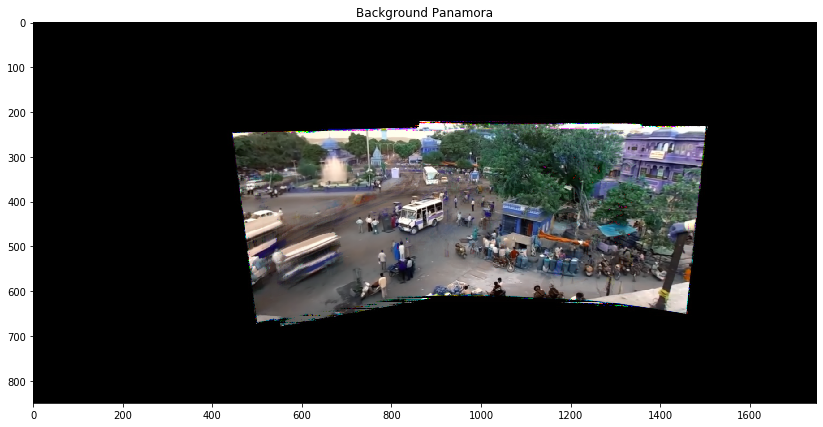

In [52]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

axes.imshow(backgroundPanorama)
axes.set_title("Background Panamora")
cv2.imwrite("part4_2.jpg", backgroundPanorama*255)

#### Part 5: Create background movie

In [53]:
import os
import cv2
import numpy as np

In [54]:
os.mkdir("part5_2")
background_images = np.zeros((900, 360, 480,3))

for idx in range(0, 723):
    invertedH = np.linalg.inv(H_t.dot(pastHomographies[idx][450]))
    projected_image = cv2.warpPerspective(backgroundPanorama, invertedH, (480, 360))
    background_images[idx,:,:,:] = projected_image
    cv2.imwrite('part5_2/a{:04d}.jpg'.format(idx), projected_image*255)

In [55]:
utils.imageFolder2mpeg('part5_2', fps=30)

#### Part 6: Create foreground movie

In [56]:
import os
import cv2
import numpy as np

In [57]:
os.mkdir("part6_2")
for idx in range(0, 723):
    difference = frames[idx] - background_images[idx]
    cv2.imwrite('part6_2/a{:04d}.jpg'.format(idx), difference*255)

In [58]:
utils.imageFolder2mpeg('part6_2', fps=30)